# Basic SHRED Tutorial on Sea Surface Temperature (SHRED V1)

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Libraries

In [27]:
# PYSHRED
from pyshred import DataManager, SHRED, SHREDEngine, LSTM_Forecaster

# Other helper libraries
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import numpy as np

#### Load in SST Data

In [28]:
mat = loadmat("SST_data.mat")
sst_data = mat['Z'].T
sst_data = sst_data.reshape(1400, 180, 360)
sst_data.shape

(1400, 180, 360)

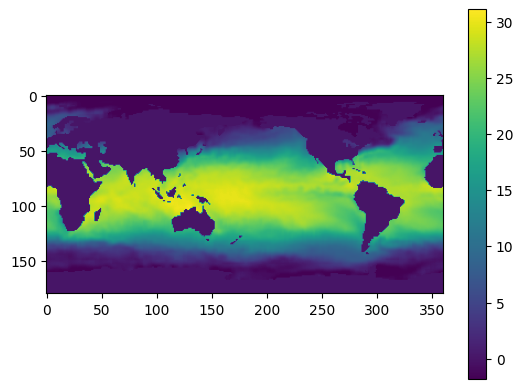

In [29]:
# Plotting a single frame
plt.figure()
plt.imshow(sst_data[0]) 
plt.colorbar()
plt.show()

#### Initialize Data Manager

In [30]:
manager = DataManager(
    lags = 52,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
)

#### Add datasets and sensors

In [31]:
manager.add_data(
    data = sst_data,
    id = "SST",
    random = 50,
    # mobile=,
    # stationary=,
    # measurements=,
    compress=False,
)

#### Analyze sensor summary

In [32]:
manager.sensor_summary_df

,data id,number,type,loc/traj
0,SST,0,stationary (random),"(62, 327)"
1,SST,1,stationary (random),"(118, 5)"
2,SST,2,stationary (random),"(14, 273)"
3,SST,3,stationary (random),"(169, 186)"
4,SST,4,stationary (random),"(115, 355)"
5,SST,5,stationary (random),"(114, 179)"
6,SST,6,stationary (random),"(153, 352)"
7,SST,7,stationary (random),"(46, 25)"
8,SST,8,stationary (random),"(27, 272)"
9,SST,9,stationary (random),"(17, 304)"


In [33]:
manager.sensor_measurements_df

data id,SST-0,SST-1,SST-2,SST-3,SST-4,SST-5,SST-6,SST-7,SST-8,SST-9,...,SST-40,SST-41,SST-42,SST-43,SST-44,SST-45,SST-46,SST-47,SST-48,SST-49
0,22.240000,21.86,-1.77,-0.0,23.059999,24.479999,-0.06,0.0,-1.80,-0.82,...,25.179999,26.249999,0.0,-0.0,26.189999,23.809999,-1.80,4.62,0.0,0.0
1,21.950000,21.55,-1.78,-0.0,23.609999,24.769999,0.52,0.0,-1.80,-1.14,...,25.029999,26.429999,0.0,-0.0,26.039999,23.009999,-1.80,3.93,0.0,0.0
2,21.450000,21.66,-1.78,-0.0,23.879999,25.649999,0.69,0.0,-1.80,-1.51,...,25.349999,26.279999,0.0,-0.0,24.999999,24.989999,-1.80,3.66,0.0,0.0
3,21.930000,20.83,-1.79,-0.0,23.209999,25.959999,1.03,0.0,-1.80,-1.68,...,25.249999,26.309999,0.0,-0.0,25.759999,24.979999,-1.80,3.91,0.0,0.0
4,21.380000,21.60,-1.79,-0.0,24.079999,26.609999,1.20,0.0,-1.80,-1.70,...,25.589999,26.579999,0.0,-0.0,25.469999,24.949999,-1.76,4.33,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,25.679999,17.03,0.31,-0.0,19.280000,22.409999,-1.74,0.0,5.26,4.25,...,24.559999,28.859999,0.0,0.0,28.459999,23.169999,-1.42,8.55,0.0,0.0
1396,25.849999,17.31,-0.39,-0.0,19.460000,22.909999,-1.76,0.0,4.04,3.82,...,24.559999,29.119999,0.0,0.0,28.129999,22.789999,-1.48,7.88,0.0,0.0
1397,25.539999,17.47,-0.30,-0.0,19.870000,22.649999,-1.80,0.0,3.28,2.07,...,24.809999,29.409999,0.0,0.0,28.159999,24.349999,-1.58,7.16,0.0,0.0
1398,25.469999,17.61,-0.79,-0.0,20.320000,22.799999,-1.80,0.0,2.70,1.66,...,24.879999,29.659999,0.0,0.0,28.709999,21.240000,-1.48,7.12,0.0,0.0


#### Get train, validation, and test set

In [34]:
train_dataset, val_dataset, test_dataset= manager.prepare()

#### Initialize a latent forecaster

In [35]:
latent_lags = 10 # number of timesteps to look back in latent space to build latent sequences
latent_forecaster = LSTM_Forecaster(lags=latent_lags)

#### Initialize SHRED

In [36]:
shred = SHRED(sequence_model="LSTM", decoder_model="SDN", latent_forecaster=latent_forecaster)

#### Fit SHRED

In [38]:
val_errors = shred.fit(train_dataset=train_dataset, val_dataset=val_dataset, num_epochs=10, thres_epoch=20, sindy_regularization=0)
print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.079269
Validation MSE (epoch 1): 0.038990
Epoch 2: Average training loss = 0.035590
Validation MSE (epoch 2): 0.033833
Epoch 3: Average training loss = 0.032686
Validation MSE (epoch 3): 0.032910
Epoch 4: Average training loss = 0.027684
Validation MSE (epoch 4): 0.018047
Epoch 5: Average training loss = 0.013167
Validation MSE (epoch 5): 0.010459
Epoch 6: Average training loss = 0.011550
Validation MSE (epoch 6): 0.010252
Epoch 7: Average training loss = 0.010622
Validation MSE (epoch 7): 0.009887
Epoch 8: Average training loss = 0.010318
Validation MSE (epoch 8): 0.009661
Epoch 9: Average training loss = 0.009913
Validation MSE (epoch 9): 0.009225
Epoch 10: Average training loss = 0.009569
Validation MSE (epoch 10): 0.008940
val_errors: [0.03899015 0.03383255 0.03290954 0.01804697 0.01045875 0.01025183
 0.00988716 0.00966144 0.00922496 0.00893991]


#### Evaluate SHRED

In [39]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.008
Val   MSE: 0.009
Test  MSE: 0.011


#### Initialize SHRED Engine for Downstream Tasks

In [40]:
engine = SHREDEngine(manager, shred)

#### Sensor Measurements to Latent Space

In [41]:
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

#### Forecast Latent Space (No Sensor Measurements)

In [44]:
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)
init_latents = val_latents[-latent_lags:] # seed forecaster with final lag timesteps of latent space from val
t = len(manager.test_sensor_measurements)
test_latent_from_forecaster = engine.forecast_latent(t=t, init_latents=init_latents)

#### Decode Latent Space to Full-State Space

In [45]:
test_prediction = engine.decode(test_latent_from_sensors) # latent space generated from sensor data
test_forecast = engine.decode(test_latent_from_forecaster) # latent space generated from latent forecasted (no sensor data)

Compare final frame in prediction and forecast to ground truth:

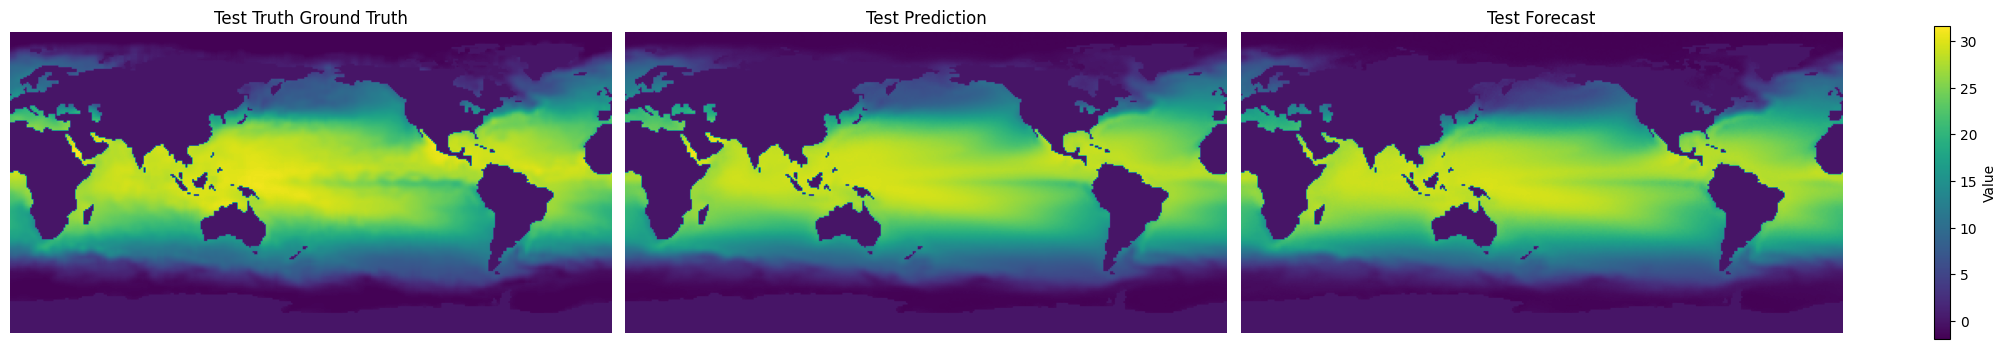

In [46]:
truth      = sst_data[-1]
prediction = test_prediction['SST'][t-1]
forecast   = test_forecast['SST'][t-1]

data   = [truth, prediction, forecast]
titles = ["Test Truth Ground Truth", "Test Prediction", "Test Forecast"]

vmin, vmax = np.min([d.min() for d in data]), np.max([d.max() for d in data])

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, d, title in zip(axes, data, titles):
    im = ax.imshow(d, vmin=vmin, vmax=vmax)
    ax.set(title=title)
    ax.axis("off")

fig.colorbar(im, ax=axes, label="Value", shrink=0.8)

#### Evaluate MSE on Ground Truth Data

In [47]:
# Train
t_train = len(manager.train_sensor_measurements)
train_Y = {'SST': sst_data[0:t_train]}
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# Val
t_val = len(manager.test_sensor_measurements)
val_Y = {'SST': sst_data[t_train:t_train+t_val]}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# Test
t_test = len(manager.test_sensor_measurements)
test_Y = {'SST': sst_data[-t_test:]}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

print('---------- TRAIN ----------')
print(train_error)
print('\n---------- VAL   ----------')
print(val_error)
print('\n---------- TEST  ----------')
print(test_error)

---------- TRAIN ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      0.401017  0.633259  0.366043  0.447007

---------- VAL   ----------
              MSE      RMSE      MAE        R2
dataset                                       
SST      0.422644  0.650111  0.37148 -0.234361

---------- TEST  ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      0.519204  0.720558  0.421799 -0.346428
